<a href="https://colab.research.google.com/github/lukekolbe/AL-in-CreditScoring/blob/main/AL_CreditScoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep runtime

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


#Setup

In [ ]:
### FOR RUNNING ON COLAB:
!pip uninstall cvxpy
!pip install cvxpy
!pip install git+https://github.com/NUAA-AL/alipy.git
!pip install hmeasure

Found existing installation: cvxpy 1.0.31
Uninstalling cvxpy-1.0.31:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/_cvxcore.cpython-37m-x86_64-linux-gnu.so
    /usr/local/lib/python3.7/dist-packages/cvxpy-1.0.31.dist-info/*
    /usr/local/lib/python3.7/dist-packages/cvxpy/*
    /usr/local/lib/python3.7/dist-packages/examples/*
Proceed (y/n)? y
  Successfully uninstalled cvxpy-1.0.31
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/NUAA-AL/alipy.git to /tmp/pip-req-build-_lt6do7v
  Running command git clone -q https://github.com/NUAA-AL/alipy.git /tmp/pip-req-build-_lt6do7v
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip freeze

In [ ]:
############ LIBRARIES

import os
import time
import datetime
import random
import multiprocessing
import pickle
import re
import copy
import gc
import sys
import json
import cvxpy

gc.enable()

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('default')
%matplotlib inline
import seaborn as sns

from itertools import cycle


import scipy.stats
from sklearn.base import clone
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score,roc_curve
from sklearn.metrics import average_precision_score, brier_score_loss, f1_score, fbeta_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import ConfusionMatrixDisplay

from hmeasure import h_score

from sklearn.linear_model import LogisticRegression

from alipy import query_strategy
from alipy.index import IndexCollection
from alipy import data_manipulate



In [ ]:
os.chdir('/gdrive/My Drive/ACTIVE LEARNING THESIS/')

In [ ]:
############ RANDOMNESS
# seed function
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
# set seed
seed = 30
seed_everything(seed)

In [ ]:
# RUN THIS ONCE TO CREATE DIRECTORIES WHERE RESULTS ARE SAVED, if not there yet
'''from pathlib import Path
for dir in ['model_indices', 'model_cost', 'model_results']:
  for dat in ['bene1','bene1','bene2','gmsc','australian','german','thomas','hmeq','lendingclub','pakdd', 'uk']:
    Path(f"{dir}/{dat}").mkdir(parents=True, exist_ok=True)'''

# Data Loader

In [ ]:
############ DATA IMPORT

def data_loader(dataset):
  
  #df = pd.read_csv('//home//RDC//kolbeluk1//AL_THESIS//prepared_data//{}.csv'.format(dataset)) #Linux path
  #df = pd.read_csv('C:\\Users\\kolbeluk1\\AL THESIS\\prepared_data\\{}.csv'.format(dataset))
  df = pd.read_csv('/gdrive/My Drive/ACTIVE LEARNING THESIS/prepared_data/{}.csv'.format(dataset))

  # remove NA
  df = df.dropna()
  df.reset_index(drop = True, inplace = True)

  #print(df)
  # extract label
  df['BAD'][df['BAD']=='BAD']  = 1
  df['BAD'][df['BAD']=='GOOD'] = 0
  df['BAD'] = df['BAD'].astype('int')


  y_temp = df['BAD']
  del df['BAD']

  #one hot encoding
  df = pd.get_dummies(df)

  #transform to numpy array >> same location for df and X
  X = df.to_numpy()
  y = y_temp.to_numpy()

  print("X type: ", type(X), "X shape: ", X.shape,"y shape: ", y.shape, "y mean: ", np.mean(y))
  print (id(X), id(df))

  return X,y


# Define Helper Functions

In [ ]:
def confusion_getter(y, accept_index, reject_index = None):

  # this function computes misclassification cost that accrues from selecting training data over the course of the experiment
  # each AL model will pick different instances to keep, so the accepted instances (i.e. credits) become increasingly different from another with each generation
  # Keeping an instance means they are effectively classified as a "good risk (p=0), different misclassification cost for different algorightms is the result

  if reject_index is not None: 
    index = np.concatenate((accept_index, reject_index)) # indices of all accepted and rejected cases used to subset y with

    #create vector of ones that has the same length as the index vector of all accepted and rejected cases combined
    #for all accepted cases, set this to zero, so that the cost performance can be computed via the confusion matrix
    prediction_scores = np.concatenate((np.zeros(len(accept_index)), np.ones(len(reject_index))))

  else:
    # first generation of any model will always land here, the oracle will always land here (no cases are ever rejected in the oracle)
    index = accept_index
    prediction_scores = np.zeros(len(index))

  #compute internal confusion matrix, which is different than the one for test prediction
  confusion_mat = confusion_matrix(y[index], prediction_scores)

  return confusion_mat

In [ ]:
def cost_function(y_true, prediction, indices_dict, cost_dict, cost_matrix, gen=0, oracle=False):

  # ---------------- EXTERNAL cost (Test prediction)
  test_idx = indices_dict['test_idx']
  confusion_mat = confusion_matrix(y_true[test_idx], prediction)

  ext_cost = np.sum(cost_matrix * confusion_mat) #dot wise product
  cost_dict['external_cost'].loc[cost_dict['generation'] == gen] = ext_cost

  # ---------------- external cost per loan (eCPL)
  ext_cpl = ext_cost / len(test_idx)
  cost_dict['external_cpl'].loc[cost_dict['generation'] == gen] = ext_cpl

  #############

  # ---------------- INITIAL COST
  # misclassification cost when using just the initial sample
  initial_conf_mat = confusion_getter(y_true, indices_dict['accept_idx'][0])
  initial_cost = np.sum(initial_conf_mat * cost_matrix)

  #############

  # ---------------- GEN INTERNAL COST
  # internal classification cost caused by this generation's samples

  accept_idx = indices_dict['gen_accept_idx'][gen]

  if not oracle:
    reject_idx = indices_dict['gen_AL_reject_idx'][gen]
    gen_int_conf_mat = confusion_getter(y_true, accept_idx, reject_idx)
  else:
    gen_int_conf_mat = confusion_getter(y_true, accept_idx)

  gen_int_cost = np.sum(cost_matrix * gen_int_conf_mat)
  cost_dict['gen_internal_cost'].loc[cost_dict['generation'] == gen] = gen_int_cost

  # ---------------- GEN internal cost per loan (CPL)

  gen_int_cpl = gen_int_cost / np.sum(gen_int_conf_mat)
  cost_dict['gen_internal_cpl'].loc[cost_dict['generation'] == gen] = gen_int_cpl


  # ---------------- TOTAL INTERNAL COST
  # all accepted cases

  accept_idx = indices_dict['accept_idx'][gen]

  if not oracle:
    reject_idx = indices_dict['total_reject_idx'][gen]
    total_int_conf_mat = confusion_getter(y_true, accept_idx, reject_idx)
  else:
    total_int_conf_mat = confusion_getter(y_true, accept_idx)

  total_int_cost = np.sum(cost_matrix * total_int_conf_mat)
  cost_dict['total_internal_cost'].loc[cost_dict['generation'] == gen] = total_int_cost

  # ---------------- TOTAL internal cost per loan (CPL)
  total_int_cpl = total_int_cost / np.sum(total_int_conf_mat)
  cost_dict['total_internal_cpl'].loc[cost_dict['generation'] == gen] = total_int_cpl


  # ---------------- MODEL INTERNAL COST
  # excluding initial sample
  # compute initial cost, subtract from total (since all models will incur this cost)
  #model_int_cost = total_int_cost - cost_dict['total_internal_cost'].loc[cost_dict['generation'] == 0] #subtract cost of initial gen
  model_int_cost = total_int_cost - initial_cost
  cost_dict['model_internal_cost'].loc[cost_dict['generation'] == gen] = model_int_cost

  # ---------------- MODEL internal cost per loan (CPL)
  #not including initial starter sample, only cost incurred by model selections

  model_int_cpl = model_int_cost / (np.sum(total_int_conf_mat) - np.sum(initial_conf_mat))
  cost_dict['model_internal_cpl'].loc[cost_dict['generation'] == gen] = model_int_cpl

  return cost_dict


In [ ]:
# prediction analyser

#define a function that does certain steps of analysis inside the loop, to be repeated at various stages of the loop
def prediction_analyser(y, prediction_raw, prediction_thresholded, results=None, gen=0, severity_ratio=None):

  ##########################################
  # metrics based on probability (no threshold)
  results['roc_auc'].loc[results['generation'] == gen] = roc_auc_score(y, prediction_raw[:,1]) #ROC AUC takes non-thresholded inputs
  results['brier'].loc[results['generation'] == gen] = brier_score_loss(y, prediction_raw[:,1])
  results['h-measure'].loc[results['generation'] == gen] = h_score(y, prediction_raw[:,1], severity_ratio = severity_ratio)
  results['average_precision'].loc[results['generation'] == gen] = average_precision_score(y, prediction_raw[:,1])
  
  # metrics based on thresholded 0/1 predictions
  results['f1'].loc[results['generation'] == gen] = f1_score(y, prediction_thresholded)
  results['precision'].loc[results['generation'] == gen] = precision_score(y, prediction_thresholded)
  results['recall'].loc[results['generation'] == gen] = recall_score(y, prediction_thresholded)
  results['balanced_accuracy'].loc[results['generation'] == gen] = balanced_accuracy_score(y, prediction_thresholded)

  # ecm : external confusion matrix (test prediction)
  ecm = confusion_matrix(y_true=y, y_pred = prediction_thresholded) ##tn, fp, fn, tp

  tn, fp, fn, tp = ecm.ravel()
  
  results['tn'].loc[results['generation'] == gen] = tn
  results['fp'].loc[results['generation'] == gen] = fp
  results['fn'].loc[results['generation'] == gen] = fn
  results['tp'].loc[results['generation'] == gen] = tp
  results['fnr'].loc[results['generation'] == gen]  = fn/(fn+tp)
  results['fpr'].loc[results['generation'] == gen]  = fp/(tn+fp)
  results['pcc'].loc[results['generation'] == gen]  = (tp+tn)/(fp+fn+tn+tp) # == accuracy

  return results

In [ ]:
# get strategy

def strategy_getter(X, y, strategy_name="QueryInstanceRandom", train_idx = None, **kwargs):
    """Return the query strategy object from alipy package"""
    
    try:
        exec("from alipy.query_strategy import " + strategy_name)
    except:
        raise KeyError("Strategy " + strategy_name + " is not implemented in ALiPy.")
    strategy = None
    
    if train_idx is not None:
      strategy = eval(strategy_name + "(X=X, y=y, train_idx = train_idx, **kwargs)")
    else:
      strategy = eval(strategy_name + "(X=X, y=y, **kwargs)")
          
    # print(strategy)
    return strategy

In [ ]:
# loader function that unpacks tuning results and extracts parameters for different model steps

def param_getter(tuned=False, dataset=None):
  if tuned:
    filename = f'{dataset}_tuned-params'

    with open(filename, 'r') as f:
      param_list = [json.loads(line) for line in f if line.startswith('{')]

    param_dict = {}
    for i in range(len(param_list)):
      strategy_short = list(param_list[i].keys())[0]
      param_dict[strategy_short] = param_list[i][list(param_list[i].keys())[0]]

    #find cases where some models are not tuned, establish base parameters
    for key, name in [('oracle', 'Oracle'),
                      ('score', 'Score'),
                      ('eer', 'QueryExpectedErrorReduction'), 
                      ('quire', 'QueryInstanceQUIRE'), 
                      ('bmdr','QueryInstanceBMDR'),
                      ('spal', 'QueryInstanceSPAL')]:
      try:
        param_dict[key]
      except KeyError:
        param_dict[key] = {'AL':{'strategy_name':name}, 'CLF':{}}

    # transfer tuned classifier to all models (clf is tuned separately, not in combination with AL model)
    for key in param_dict.keys():
      param_dict[key]['CLF']=param_dict['random']['CLF']

    for key in ['bmdr', 'spal']:
      param_dict[key]['AL']['rho'] = 10 #setting the rho parameter to 10 increases computation speed considerably

  '''
  else:
    param_dict = {'oracle': {'AL':{'strategy_name': 'Oracle'}, 'CLF':{}}
                  ,'score': {'AL':{'strategy_name': 'Score'}, 'CLF':{}}
                  ,'random': {'AL':{'strategy_name': 'QueryInstanceRandom'}, 'CLF':{}}
                  ,'unc': {'AL':{'strategy_name': 'QueryInstanceUncertainty'}, 'CLF':{}}
                  ,'qbc': {'AL':{'strategy_name': 'QueryInstanceQBC'}, 'CLF':{}}
                  ,'eer': {'AL':{'strategy_name': 'QueryExpectedErrorReduction'}, 'CLF':{}}
                  ,'dw': {'AL':{'strategy_name': 'QueryInstanceDensityWeighted'}, 'CLF':{}}
                  ,'density':{'AL':{'strategy_name': 'QueryInstanceGraphDensity'}, 'CLF':{}}
                  ,'cors' :  {'AL':{'strategy_name': 'QueryInstanceCoresetGreedy'}, 'CLF':{}}
                  ,'quire': {'AL':{'strategy_name': 'QueryInstanceQUIRE'}, 'CLF':{}}
                  ,'bmdr': {'AL':{'strategy_name': 'QueryInstanceBMDR'}, 'CLF':{}}
                  ,'spal': {'AL':{'strategy_name': 'QueryInstanceSPAL'}, 'CLF':{}}
                  ,'lal': {'AL':{'strategy_name': 'QueryInstanceLAL'}, 'CLF':{}}
                  }
  '''
  return param_dict

In [ ]:
# create dictionary of setup parameters fed into the main loop

def loop_param_setter(X, max_gens = 10, total_rounds=5, init_ratio = 0.1, AL_acc_rate = 0.5, weights=True, cost_mat = None, dataset = None):

  #max_gens = 10 per round (outer loop) this parameter sets the number of generations of applicants (inner loop)
  #total_rounds = 5 #number of loop iterations, important for Stratified Kfold splitting of data
  #init_ratio = 0.1

  init_size, sample_size  = split_sample_calc(X, init_ratio, total_rounds, max_gens)

  LOOP_params = {'rounds': total_rounds,
            'max_gens': max_gens,
            'init_sample': init_size, # initial labaled sampel; is defined at the beginning
            'sample_size': sample_size, # number of applicants for each iteration
            'score_acc_rate': 1-AL_acc_rate, # score_accept_rate: share OF APPLICANTS that are accepted by score (total share is dependent on threshold, too!)
            'AL_acc_rate': AL_acc_rate, # AL_accept_rate: share OF APPLICANTS that are accepted by AL

            'weights': weights, #sample weights
            'w_factor': np.round((1-AL_acc_rate) / AL_acc_rate, 4),
            
            'cost_matrix': cost_mat, #[[0, 1],[5, 0]] #TN, FP, FN, TP
            'do_thres': 'tuned', # do threshold; either 'tuned', "mean", "roc", "youden" or 'none'
            'tuned_threshold': tuned_thresholds[dataset],
            'dataset_name': dataset
            }

  return LOOP_params

In [ ]:
# function for calculating split and sample sizes
# ensure that max_gens are possible with the data

def split_sample_calc(X, init_size=0.1, total_rounds=5, max_gens=10):
  #size of the initially labeled sample
  #the term (len(X)-100) is used to leave some buffer so that the loop will be able to query a stratified sample in the last generation without issues due to a missing class.
  #factor (1-1/total_rounds) is used because one of k folds is used as test set, therefore not being available for training.
  available_data = int((len(X)-100) * (1-1/total_rounds))
  print("available_data", available_data)
  s_initial = int(init_size*available_data)

  #sample size to draw in each generation
  s_size = int((available_data - s_initial) / max_gens)

### these values are aribitrarily chosen! NEEDS REASONING
  if s_initial > 500:
    s_initial = 500

  if s_size > s_initial:
    s_size = s_initial
  print(s_initial, s_size)
  return s_initial, s_size

## Plots

In [ ]:
def stats_plotter(stats):  # plot size
  fig = plt.figure(figsize = (30, 45))

  plt.subplot(7, 2, 1)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['roc_auc'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.xlabel('Generation', fontsize = 15)
    plt.ylabel('ROC AUC score',        fontsize = 15)
    plt.legend(prop = {'size': 12}, loc='upper center', bbox_to_anchor=(0.7, 0.4),
          fancybox=True, shadow=True, ncol=3)

  plt.subplot(7, 2, 2)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['h-measure'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.ylabel('h-measure',        fontsize = 15)

  # Brier-score
  plt.subplot(7, 2, 3)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats)))) 
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['brier'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.ylabel('Brier score',        fontsize = 15)

  # f1-score
  plt.subplot(7, 2, 4)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['average_precision'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.ylabel('Average Precision', fontsize = 15)

  plt.subplot(7, 2, 5)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['balanced_accuracy'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.ylabel('Balanced Accuracy', fontsize = 15)

  # h-measure
  plt.subplot(7, 2, 6)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['f1'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.ylabel('F1 score',        fontsize = 15)
 

  plt.subplot(7, 2, 7)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['pcc'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.ylabel('Precentage of correctly classified', fontsize = 15)
 

  # FNR
  plt.subplot(7, 2, 9)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['fnr'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.ylabel('False Negative Rate (FNR)\nof test-prediction',        fontsize = 15)

  # FPR
  plt.subplot(7, 2, 10)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['fpr'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.ylabel('False Positve Rate (FPR)\nof test-prediction', fontsize = 15)

  # Bad Ratio Accepted Instances
  plt.subplot(7, 2, 11)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    c=next(color)
    l=next(lines)
    # absoute values
    plt.plot(stats["{}".format(key)]['average']['bad_ratio_accepts'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
    plt.ylabel('Bad ratio of accepted cases', fontsize = 15)
    

  # Bad Ratio Rejected Instances
  plt.subplot(7, 2, 12)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    if key not in ["oracle"]:
      c=next(color)
      l=next(lines)
      # absoute values
      plt.plot(stats["{}".format(key)]['average']['bad_ratio_rejects'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
      plt.ylabel('Bad ratio of rejected cases',        fontsize = 15)

    else:
      c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
      l=next(lines)


  # Bad Ratio SCORE Instances
  plt.subplot(7, 2, 13)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    if key not in ["oracle"]:
      c=next(color)
      l=next(lines)
      # absoute values
      plt.plot(stats["{}".format(key)]['average']['bad_ratio_AL_selects'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
      plt.ylabel('Bad ratio of AL-selected cases',        fontsize = 15)

    else:
      c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
      l=next(lines)

  # Bad Ratio SCORE Instances
  plt.subplot(7, 2, 14)
  color=iter(cm.rainbow(np.linspace(0,1,len(stats))))
  lines = cycle(["-","--","-.",":"])
  for key in stats.keys():
    if key not in ["oracle"]:
      c=next(color)
      l=next(lines)
      # absoute values
      plt.plot(stats["{}".format(key)]['average']['bad_ratio_score_accepts'], c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
      plt.ylabel('Bad ratio of score-selected cases',        fontsize = 15)

    else:
      c=next(color) #skip one color because we don't need a curve for oracle and want to maintain color scheme
      l=next(lines)


In [ ]:

############ COST PLOTS
def cost_plotter(cost, cost_metrics):  # plot size

  if len(cost_metrics)%2 > 0:
    plotrows = (len(cost_metrics) + 1) / 2

  else:
    plotrows = (len(cost_metrics)) / 2

  fig = plt.figure(figsize = (20, 20))


  for q in cost_metrics:

    # External cost
    plt.subplot(plotrows, 2, (cost_metrics.index(q) + 1))
    color=iter(cm.rainbow(np.linspace(0,1,len(cost))))
    lines = cycle(["-","--","-.",":"])
    
    for key in cost.keys():
      #if key not in ["score"]:
        c=next(color)
        l=next(lines)
        # absoute values
        plt.plot((cost["{}".format(key)]['average'][q]), c=c, ls=l, label = AL_models[key][0],  linewidth = 2)
        plt.xlabel('Generation', fontsize = 15)
        plt.ylabel(f'{q}', fontsize = 15)

        if cost_metrics.index(q) < 1:
          plt.legend(prop = {'size': 10}, loc='upper right', bbox_to_anchor=(0.9, 0.9),
          fancybox=True, shadow=True, ncol=3)


# Define AL Loop

In [ ]:
def AL_loop(data, y, kf_indices, key,  AL_models, rounds = 5, classifier=None, iteration=0, max_gens=10, sample_size=500, init_sample=500, score_acc_rate=0.5, AL_acc_rate=0.5, seed=1, weights=False, w_factor=1, do_thres='tuned', tuned_threshold=None, AL_params=None, CLF_params=None, cost_matrix=None, dataset_name = None): #test_ratio = 0.3
  #check validity and completeness of parameters
  print('\n\n\n---------------------------------------------------')
  local_parameters = locals()
  print('PARAMETERS:\n')
  for l_p in local_parameters:
    if l_p not in ['data', 'y', 'kf_indices','AL_models', 'classifier']:
      print(f'{l_p}: ', local_parameters[l_p])

  ##########################################
  # MISC LOOP SETUP
  ##########################################
  seed_everything(seed)
  
  ##############
  # use train-test indices via StratifiedKFold object passed as argument
  train_idx = kf_indices[iteration][0]
  test_idx = kf_indices[iteration][1]

  #draw a stratified sample as initial labeled data
  sss = StratifiedShuffleSplit(n_splits=1, test_size=init_sample, random_state=seed)
  for unlabel, label in sss.split(X=data[train_idx], y=y[train_idx]):
    unlabel_idx, accept_idx = np.asarray(unlabel), np.asarray(label)    

  unlabel_idx = IndexCollection(unlabel_idx)
  accept_idx = IndexCollection(accept_idx)

  #### APPLY ROBUST SCALER
  # scale once for each round (not each generation within the round) using the initial labeled set
  # in some cases this is a very small set to scale on...
  scaler = RobustScaler(with_centering=True, with_scaling=True)
  scaler.fit(data[accept_idx.index,:])
  X_t = scaler.transform(np.array(data)) #scaled version of full dataset
  

  # calculate the actual number of generations that can be drawn from the data, in case max_gens * sample_size exceeds available training size
  # num_gens = int((np.min(len(train_idx), len(test_idx)) - init_sample) / sample_size)
  num_gens = int((len(train_idx) - init_sample) / sample_size)
  num_gens = np.min([num_gens, max_gens])
  print("strategy {}, round {}: running loop for {} generations".format(AL_models[key][0], iteration, num_gens))

  #initialize results dataframe
  stats = pd.DataFrame({'generation':    range(num_gens+1),
                    'n_accepts':         np.nan, #total number of accepts
                    'n_rejects':         np.nan, #total number of rejects               
                    'bad_ratio_accepts': np.nan,
                    'bad_ratio_rejects': np.nan,
                    'n_score_accepts':   np.nan,
                    'n_AL_selects':      np.nan,
                    'bad_ratio_score_accepts': np.nan,
                    'bad_ratio_AL_selects': np.nan,

                    'roc_auc':           np.nan,
                    'brier':             np.nan,
                    'h-measure':         np.nan,
                    'average_precision': np.nan,
                    'balanced_accuracy': np.nan,
                    'pcc':               np.nan, # same as accuracy

                    'precision':         np.nan,
                    'recall':            np.nan,
                    'f1':                np.nan, 
                    'fpr':               np.nan,
                    'fnr':               np.nan,

                    'tn':                np.nan,
                    'fp':                np.nan,
                    'fn':                np.nan,
                    'tp':                np.nan
                    #'time':             np.nan
                       })

  cost = pd.DataFrame({
          'generation': range(num_gens+1),

          'gen_internal_cost': np.nan,
          'gen_internal_cpl': np.nan,

          'total_internal_cost': np.nan,
          'total_internal_cpl':np.nan, #cost per loan

          'model_internal_cost': np.nan,
          'model_internal_cpl': np.nan,

          'external_cost': np.nan,
          'external_cpl': np.nan
          }
          )

  # store indices that were drawn, needed mostly for debugging and plausibility checking
  indices = {'test_idx': [],
              'train_idx': [],
             
              'applicants_idx': {},     # in each gen, new applicants are randomly drawn
                         
              'gen_score_accept_idx':  {},    # top n accepted cases based on prediction score
              'gen_score_reject_idx':  {},    # rejected cases based on prediction score
              'gen_AL_select_idx':  {},   # this gen's AL selection
              'gen_AL_reject_idx':  {},   # not picked by either Score or 
              'gen_accept_idx': {},
              
              'total_score_accept_idx': {},
              'total_AL_select_idx': {},  # all instances that were accepted via AL over all rounds
              'total_reject_idx': {},    # 
              'accept_idx':  {},
              }
  
  
  indices['test_idx'] = test_idx
  indices['train_idx'] = train_idx
  indices['accept_idx'][0] = accept_idx.index
  indices['gen_accept_idx'][0] = accept_idx.index

  

  ##########################################
  # SET INITIAL PERFORMANCE POINT WITH INITIAL SAMPLE
  ##########################################
  clf = clone(classifier, safe=True) #clone in order to receive fresh classifier
  clf.set_params(**CLF_params)
  print('classifier: ',str(clf))

  clf.fit(X=X_t[accept_idx.index,:], y=y[accept_idx.index]) ### first fit as basline, no AL selection was performed yet
  
  prediction = clf.predict_proba(X_t[test_idx, :])

  # compute threshold candidates
  # roc curve is computed just once, in generation 0, so that thresholds are fixed for the entirety of the run
  fpr, tpr, thresholds = roc_curve(y[test_idx],prediction[:,1],drop_intermediate=True)
  threshold_dict = {'mean': np.round(np.mean(y[accept_idx.index]),6),
                'roc': np.round(thresholds[np.argmin(np.abs(fpr+tpr-1))],6),
                'youden': np.round(thresholds[np.argmax((tpr-fpr))],6),
                'none': 0.5,
                'tuned': np.round(tuned_threshold,6)
                }

  print('thresholds: ',threshold_dict)


  ##########################################
  # Calculate performance metrics for baseline, using (thresholded) prediction

  print('threshold used: ',threshold_dict[do_thres])
  pred_thres = (prediction[:,1] >= threshold_dict[do_thres]).astype(int)
  print("mean of thresholded prediction: ", np.mean(pred_thres))
  print('percentage kept: ',1-np.mean(pred_thres))


  # INITIAL COST
  # Establish cost-matrix

  if cost_matrix == None:
    y_mean = np.mean(y)
    fn_cost = (1-y_mean)/y_mean
    cost_matrix = np.array([[0, 1],[fn_cost, 0]]) # [tn, fp], [fn, tp]
  else:
    fn_cost = cost_matrix[1][0]

  severity = 1/fn_cost # used for h-measure
  print('cost matrix [[tn, fp], [fn, tp]]: ', cost_matrix)
  
  # run cost function for initial data, gen = 0, set oracle = True because no rejects exist yet, same as when running the oracle model
  cost = cost_function(y, pred_thres, indices, cost, cost_matrix, oracle=True)

  # run the prediction analyser function for further performance metrices
  stats = prediction_analyser(y[test_idx], prediction, pred_thres, stats, gen=0, severity_ratio=severity)
  # save indices and bad ratios of initial round
  # this is just the baseline; since initial accepts are randomly selected, the ratios between accepted and rejected cases will be identical here
  indices['accept_idx'][0] = accept_idx.index  #store initially accepted indices
  stats['bad_ratio_accepts'].loc[stats['generation'] == 0] = np.round(np.mean(y[accept_idx.index]), 4)
  stats['bad_ratio_rejects'].loc[stats['generation'] == 0] = np.round(np.mean(y[unlabel_idx.index]), 4)



  ########################################################################
  # LOAD AL Strategies
  ########################################################################

  #name = AL_models[key][1]
  if key in ["random", "unc", "qbc", "eer", "dw"]:
    strategy = strategy_getter(X_t, y, **AL_params) #, **, al_hyperparameters

  elif key == "lal":
    reg_est = AL_params['reg_est']
    reg_depth = AL_params['reg_depth']
    reg_feat = AL_params['reg_feat']
    cls_est = AL_params['cls_est']

    strategy = strategy_getter(X_t, y, strategy_name= 'QueryInstanceLAL', mode='LAL_iterative', train_slt=False, cls_est = cls_est) #**param_dict
    strategy.download_data()
    strategy.train_selector_from_file(reg_est=reg_est, reg_depth=reg_depth, feat=reg_feat)
  
  elif key in ["cors", "density", "quire", "bmdr", "spal"]:
    # these AL models need actual training indices and must hence be initialized in every generation of the loop, 
    # using the newest accepts and rejects from the current generation
    pass


  # timer
  loop_start = time.time()
  
  ########################################################################
  # ACCEPTANCE LOOP with AL
  ########################################################################
  for g in range(num_gens):
    print('---------------------------------------------------')
    print(f'dataset {dataset_name}, strategy {key}, AL ratio {AL_acc_rate}, cost matrix {cost_matrix}: starting round {iteration}, gen{g+1}')

    seed_everything(seed)
    
    ##########################################
    # DRAW APPLICANTS IN EACH GENERATION
    # we draw a stratified sample from the unlabeled indices to avoid samples without minority class instances
    # break condition prior to meeting num_gens when not enough unlabeled instances to draw a full sample containing both classes
    # this is done because StratifiedShuffleSplit works with float test sizes
    ##########################################

    if sample_size < len(unlabel_idx.index) and 1 > np.mean(y[unlabel_idx.index]) > 0:
      sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=seed) # THESE ARE POSITIONS, NOT INDICES
      
      for dump_idx, use_idx in sss.split(X=np.zeros(len(unlabel_idx.index)), y=y[unlabel_idx.index]): #just splitting on y, hence X provided as zeros
        sss_applicants_pos = np.asarray(use_idx) #Yields positions of applicants in UNLABEL INDEX
      
      applicants_idx = np.array(unlabel_idx.index)[sss_applicants_pos]
      applicants_idx = IndexCollection(applicants_idx)
      unlabel_idx.difference_update(applicants_idx) # delete applicants_idx from unlabel_idx
    
    else:
      break #break loop if not enough instances are left or only instances of one class remain
    
    #add applicants to indices dictionary
    #should be the same for every strategy & round >> just a plausibility check
    indices['applicants_idx'][g+1] = applicants_idx.index 

    ##########################################
    # SELECT AND SCORE APPLICANTS
    ##########################################

    ## PREDICTION ON APPLICANTS, NOT NEEDED FOR ORACLE
    applicants_pred = clf.predict_proba(X_t[applicants_idx.index, :])
 
    if key == 'oracle':
      # accept all applicants for "oracle" model
      accept_idx.update(applicants_idx)
      indices['gen_accept_idx'][g+1] = applicants_idx.index

      #save bad ratios of oracle
      stats['bad_ratio_accepts'].loc[stats['generation'] == g+1] = np.round(np.mean(y[accept_idx.index]), 4)
    

    else:
      ## make score-based selections
      # apply threshold
      # determine the number of instances that score below the threshold, set that number as the maximum number to be accepted by both score and AL-criteria combined.

      applicants_pred_thres = (applicants_pred[:,1] >= threshold_dict[do_thres]).astype(int) #set any prediction reaching or exceeding threshold to 1
      print('percentage of applicants kept (cutoff based on threshold): ',1-np.mean(applicants_pred_thres))

      n_instances = len(np.where(applicants_pred[:,1] <= threshold_dict[do_thres])[0])
      #n_instances = int(np.sum(applicants_pred_thres))
      score_instances = int(score_acc_rate * n_instances)
      al_instances = int(AL_acc_rate * n_instances)
      if score_instances + al_instances >= len(applicants_idx.index):
        score_instances -=1 #reject at least one instance
        print('VERY HIGH ACCEPTANCE RATE, THRESHOLD FIT LIKELY BAD')

      #failsafe for strict thresholds
      #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      # what is the best fallback here?
      if al_instances < 1:
        print('TOO FEW AL SELECTIONS, APPLYING FAILSAFE')
        al_instances = 1

      #if score_instances < 1:
        #print('TOO FEW SCORE SELECTIONS, APPLYING FAILSAFE')
        score_instances = int(al_instances * (score_acc_rate/AL_acc_rate))
      #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      print(f"number of instances to be selected: total = {n_instances}; score = {score_instances}; AL = {al_instances}")

      # get indices that sort the predictions (ascending)
      sorted_pos = np.argsort(applicants_pred[:,1])
      print("len sorted_pos", len(sorted_pos))

      #get indices of top-ranking (lowest prediction) n instances
      score_accept_pos = sorted_pos[:score_instances]
      print("len score_accept_pos", len(score_accept_pos))

      #get indices that remain (not picked)
      al_pos = sorted_pos[score_instances:]

      #save indices of score selection
      gen_score_accept_idx = np.asarray(applicants_idx.index)[score_accept_pos] # get actual indices based on positions
      gen_score_accept_idx = IndexCollection(gen_score_accept_idx)
      accept_idx.update(gen_score_accept_idx) # add top ranking applicants to overall accepted cases
      print("number of score-accepted applicants: ",len(gen_score_accept_idx))

      #gen_score_reject_idx = IndexCollection(np.asarray(applicants_idx.index)[al_pos])
      gen_score_reject_idx = IndexCollection(np.asarray(applicants_idx.index))
      gen_score_reject_idx.difference_update(gen_score_accept_idx)
      
      print("length of gen_score_reject_idx:", len(gen_score_reject_idx.index))
      
    print('model key: ', key)
      


    ####################################################################################
    # 2nd STEP: PERFORM AL-SELECTION OF APPLICANTS
    ####################################################################################

    if key != 'oracle': #, 'score'

      ##########################################
      # SETUP
      ##########################################

      print('no. of AL-accepted instances:', al_instances)

      if key in ["cors", "density", "quire"]:
        al_idx=np.concatenate((np.asarray(accept_idx.index), np.asarray(gen_score_reject_idx.index)))
        strategy = strategy_getter(X_t, y, train_idx=al_idx, **AL_params)

      ##########################################
      # MAKE SELECTION
      ##########################################

      if key == 'score':

        #get indices for AL selection, which in case of SCORE just means the next-best ranking instances (applicants) according to the prediction
        al_pos = sorted_pos[score_instances:(score_instances+al_instances)]

        gen_AL_select_idx = np.asarray(applicants_idx.index)[al_pos]
        gen_AL_select_idx = IndexCollection(gen_AL_select_idx)
      
      elif key == 'quire':
        print(strategy)
        ## quire has no batch mode, instances are selected one by one >> so a loop is needed
        gen_AL_select_idx = np.zeros(shape=al_instances, dtype=int) #empty array to be filled with selected indices
        labeled_temp = IndexCollection(accept_idx.index)
        unlabeled_temp = IndexCollection(gen_score_reject_idx.index)

        print('starting QUIRE selection')
        for n in range(al_instances):
          selection = strategy.select(label_index=labeled_temp.index, unlabel_index=unlabeled_temp.index)[0] # returns a list of len one, hence the [0]
          labeled_temp.update(selection)
          unlabeled_temp.difference_update(selection)

          gen_AL_select_idx[n] = selection
          if n%10 == 0:
            print(f"QUIRE selected {n} cases:", gen_AL_select_idx)
      
        gen_AL_select_idx = IndexCollection(gen_AL_select_idx)


      elif key in ['bmdr', 'spal']:
        # select instances for this gen and AL Model
        '''SPECIAL CASE: similar to QUIRE and some other techniques, BMDR and SPAL build distance matrices upon which their selections are calculated.
        But unlike QUIRE etc., BMDR and SPAL do not take a training index as parameter, which would be used to subset the data and reduce the size of the distance matrix.
        For large datasets, this means that the distance matrix for the rbf kernel (using the full dataset) would become very large, requiring hundreds of GB of RAM.
        This workaround reduces the input data to only a relevant subset, builds proxy-indices (indices of indices), makes a selection, 
        and transates the selected indices of the subset to indices that work for the whole dataset.'''

        al_idx=np.concatenate((np.asarray(accept_idx.index), np.asarray(gen_score_reject_idx.index)))
        strategy = strategy_getter(X_t[al_idx], y[al_idx], **AL_params)
        
        temp_accept_idx = list(range(len(accept_idx.index)))
        temp_unlabel_idx = [x + len(temp_accept_idx) for x in list(range(len(gen_score_reject_idx.index)))]
        temp_gen_AL_select_idx = strategy.select(label_index=temp_accept_idx, unlabel_index=temp_unlabel_idx, batch_size=al_instances, model=clf, qp_solver = 'OSQP') 

        gen_AL_select_idx = al_idx[temp_gen_AL_select_idx]
        gen_AL_select_idx = IndexCollection(gen_AL_select_idx)

      else:
        # select instances for this gen and AL Model
        gen_AL_select_idx = strategy.select(label_index=accept_idx, unlabel_index=gen_score_reject_idx, batch_size=al_instances, model=clf) 
        gen_AL_select_idx = IndexCollection(gen_AL_select_idx)

      indices['gen_AL_select_idx'][g+1] = gen_AL_select_idx.index #Different for every model
      indices['gen_accept_idx'][g+1] = np.concatenate((gen_AL_select_idx.index, gen_score_accept_idx.index))
    

      ## add score and AL selected instances to accept_idx
      gen_score_reject_idx.difference_update(gen_AL_select_idx) # after subtracting the AL selections, the remaining samples in the index are ultimately rejected
      accept_idx.update(gen_score_accept_idx)
      accept_idx.update(gen_AL_select_idx)
      print('len accept_idx after round update', len(accept_idx.index))
      print('len gen_score_reject_idx after round update', len(gen_score_reject_idx))

      ####################################################################################
      # Save rejected and accepted cases
      ####################################################################################
          
      if g == 0:
        total_score_accept_idx = IndexCollection(np.array(gen_score_accept_idx.index))
        total_reject_idx = IndexCollection(np.array(gen_score_reject_idx.index)) # define total reject index list in initial generation, update after
        total_AL_select_idx = IndexCollection(np.array(gen_AL_select_idx.index))

      else:
        total_score_accept_idx.update(gen_score_accept_idx)
        total_reject_idx.update(gen_score_reject_idx)
        total_AL_select_idx.update(gen_AL_select_idx)

      indices['total_reject_idx'][g+1] = total_reject_idx.index 
      indices['total_score_accept_idx'][g+1] = total_score_accept_idx.index 
      indices['gen_score_accept_idx'][g+1] = gen_score_accept_idx.index 
      indices['gen_score_reject_idx'][g+1] = gen_score_reject_idx.index  

      gen_score_reject_idx.difference_update(gen_AL_select_idx) ## remove AL selects from (score) rejected cases
      indices['gen_AL_reject_idx'][g+1] = gen_score_reject_idx.index

      #indent removed, because I actually do get gen_AL_select_idx from the score model, even though the naming is imprecise
      indices['total_AL_select_idx'][g+1] = total_AL_select_idx.index #Different for every model
      stats['n_AL_selects'].loc[stats['generation'] == g+1] = len(total_AL_select_idx.index)
      stats['bad_ratio_AL_selects'][g+1] = np.round(np.mean(y[total_AL_select_idx.index]), 4) 
      stats['bad_ratio_rejects'].loc[stats['generation'] == g+1] = np.round(np.mean(y[total_reject_idx.index]), 4)
      stats['bad_ratio_score_accepts'][g+1] = np.round(np.mean(y[total_score_accept_idx.index]), 4) # different to some degree      
      stats['n_rejects'].loc[stats['generation'] == g+1] = len(total_reject_idx.index)
      stats['n_score_accepts'].loc[stats['generation'] == g+1] = len(total_score_accept_idx.index)      

    # same for all models
    stats['n_accepts'].loc[stats['generation'] == g+1] = len(accept_idx.index)
    indices['accept_idx'][g+1] = accept_idx.index
    stats['bad_ratio_accepts'].loc[stats['generation'] == g+1] = np.round(np.mean(y[accept_idx.index]), 4)

    ##########################################
    # PREDICTION TEST SCORING OF SELECTED INSTANCES, GATHER PERFORMANCE METRICS
    ##########################################

    if weights and key not in ['oracle', 'score']:
      # use sample weights in fitting
      ### not too efficient to save "total_AL_select_idx" and re-initialize sample_weights every gen... 
      ### A smarter solution would just add correct weights dynamically

      #find matches in AL select and accept indices and set weights for these rows
      sample_weights=np.ones(len(accept_idx.index))
      sample_weights[np.where(np.in1d(accept_idx.index, total_AL_select_idx.index, assume_unique=True, invert=False))] = w_factor 
      print('no. of weighted samples', np.sum(sample_weights)/w_factor)
      clf.fit(X=X_t[accept_idx.index, :], y=y[accept_idx.index], sample_weight=sample_weights)
    
    else:
      # fit clf again with all selected instances
      clf.fit(X=X_t[accept_idx.index, :], y=y[accept_idx.index]) 
    
    ##########################################
    # predict on TEST
    ##########################################
    test_prediction = clf.predict_proba(X_t[test_idx, :])
    print(f'mean of gen {g+1} TEST prediction:', np.mean(test_prediction[:,1]))
    
    test_pred_thres = (test_prediction[:,1] >= threshold_dict[do_thres]).astype(int) #set any prediction reaching or exceeding threshold to 1


    ### COMPUTE & COLLECT Test prediction performance AND INTERNAL & EXTERNAL COST for this generation
    stats = prediction_analyser(y[test_idx], test_prediction, test_pred_thres, stats, gen=g+1, severity_ratio=severity)
    
    if key == 'oracle':
      cost = cost_function(y, test_pred_thres, indices, cost, cost_matrix, gen = g+1, oracle=True)
    elif len(gen_score_reject_idx) == 0:
      cost = cost_function(y, test_pred_thres, indices, cost, cost_matrix, gen = g+1, oracle=True)
    else:
      cost = cost_function(y, test_pred_thres, indices, cost, cost_matrix, gen = g+1, oracle=False)
    
    ################################################################################################################
    # display some info at the end of every second round
    ################################################################################################################

  # if (g % 2 == 0):
    if key == "oracle":
      print(f'gen {g+1}/{num_gens} | # applicants = {len(applicants_idx.index)} | score accepts = NaN | AL selects = NaN | total accepts = {len(accept_idx.index)} | unlabelled = {len(unlabel_idx.index)} |  time = {((time.time() - loop_start) / 60):.2f} min')
    elif key == 'score':
      print(f'gen {g+1}/{num_gens} | # applicants = {len(applicants_idx.index)} | score accepts = {len(gen_score_accept_idx.index)} | AL selects = NaN | total accepts = {len(accept_idx.index)} | unlabelled = {len(unlabel_idx.index)} |  time = {((time.time() - loop_start) / 60):.2f} min')
    else:
      print(f'gen {g+1}/{num_gens} | # applicants = {len(applicants_idx.index)} | score accepts = {len(gen_score_accept_idx.index)} | AL selects = {len(gen_AL_select_idx.index)} | total accepts = {len(accept_idx.index)} | unlabelled = {len(unlabel_idx.index)} |  time = {((time.time() - loop_start) / 60):.2f} min')
      #AL = {len(total_AL_select_idx.index)} | total rejects = {len(total_reject_idx.index)} |
      #.format(g, num_gens, len(applicants_idx.index), len(accept_idx), len(unlabel_idx), (time.time() - loop_start) / 60))  # strategy{} >> re.search('query_labels.(.+?)\'>', str(strategy.__class__)).group(1)
  
  print(cost)
  print('\n Finished {} generations in {:.2f} minutes'.format(num_gens, (time.time() - loop_start) / 60), '\n \n \n -------------------------------------------------')

  return stats, indices, cost

# Prepare and run loop

In [ ]:
## available datasets

  # gmsc             # shape:  (150000, 68)
  # uk               # shape:  (30000, 51), y mean:  0.04
  # lendingclub      # shape:  (41623, 114) y mean:  0.1331235134420873    
  # bene2            # shape:  (7190, 28)
  # bene1            # shape:  (3123, 18)
  # hmeq             # shape:  (5960, 20)
  # australian       # shape:  (690, 42)
  # german           # shape:  (1000, 61)
  # thomas           # shape:  (1225, 28)
  # pakdd            # shape:  (50000, 373), y mean:  0.26082

# datasets to run loop over:
#dataset_list = [ "australian","german","gmsc","bene1","bene2",'uk','hmeq','lendingclub','pakdd','thomas']
dataset_list = [ "australian"]

ratios_list = [0.1,0.2,0.3,0.4,0.5]
cost_mat_list = [None]

weights = [True, False] #apply sample weights?

### Training parameters
rounds = 5 #do not change, always 5
max_gens = 10
tuned = True # do not change, always run tuned data, exists just as a debugging option to run all AL models on default parameters
store_indices = False #set this if all indices should be stored as well. Not needed for subsquent analysis, just as a backup

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
---------------------------------------------------
dataset australian, strategy quire, AL ratio 0.3, cost matrix [[0.       1.      ]
 [1.247557 0.      ]]: starting round 0, gen10
percentage of applicants kept (cutoff based on threshold):  0.5476190476190477
number of instances to be selected: total = 23; score = 16; AL = 6
len sorted_pos 42
len score_accept_pos 16
number of score-accepted applicants:  16
length of gen_score_reject_idx: 26
model key:  quire
no. of AL-accepted instances: 6
starting QUIRE selection
QUIRE selected 0 cases: [202   0   0   0   0   0]
len accept_idx after round update 291
len gen_score_reject_idx after round update 20
no. of weighted samples 165.287061243732
mean of gen 10 TEST prediction: 0.44641510682993235
gen 10/10 | # applicants = 42 | score accepts = 16 | AL selects = 6 | total accepts = 291 | unlabelled = 85 |  time = 0.03 min
    generation  gen_internal_cost  gen_internal_cpl  tota

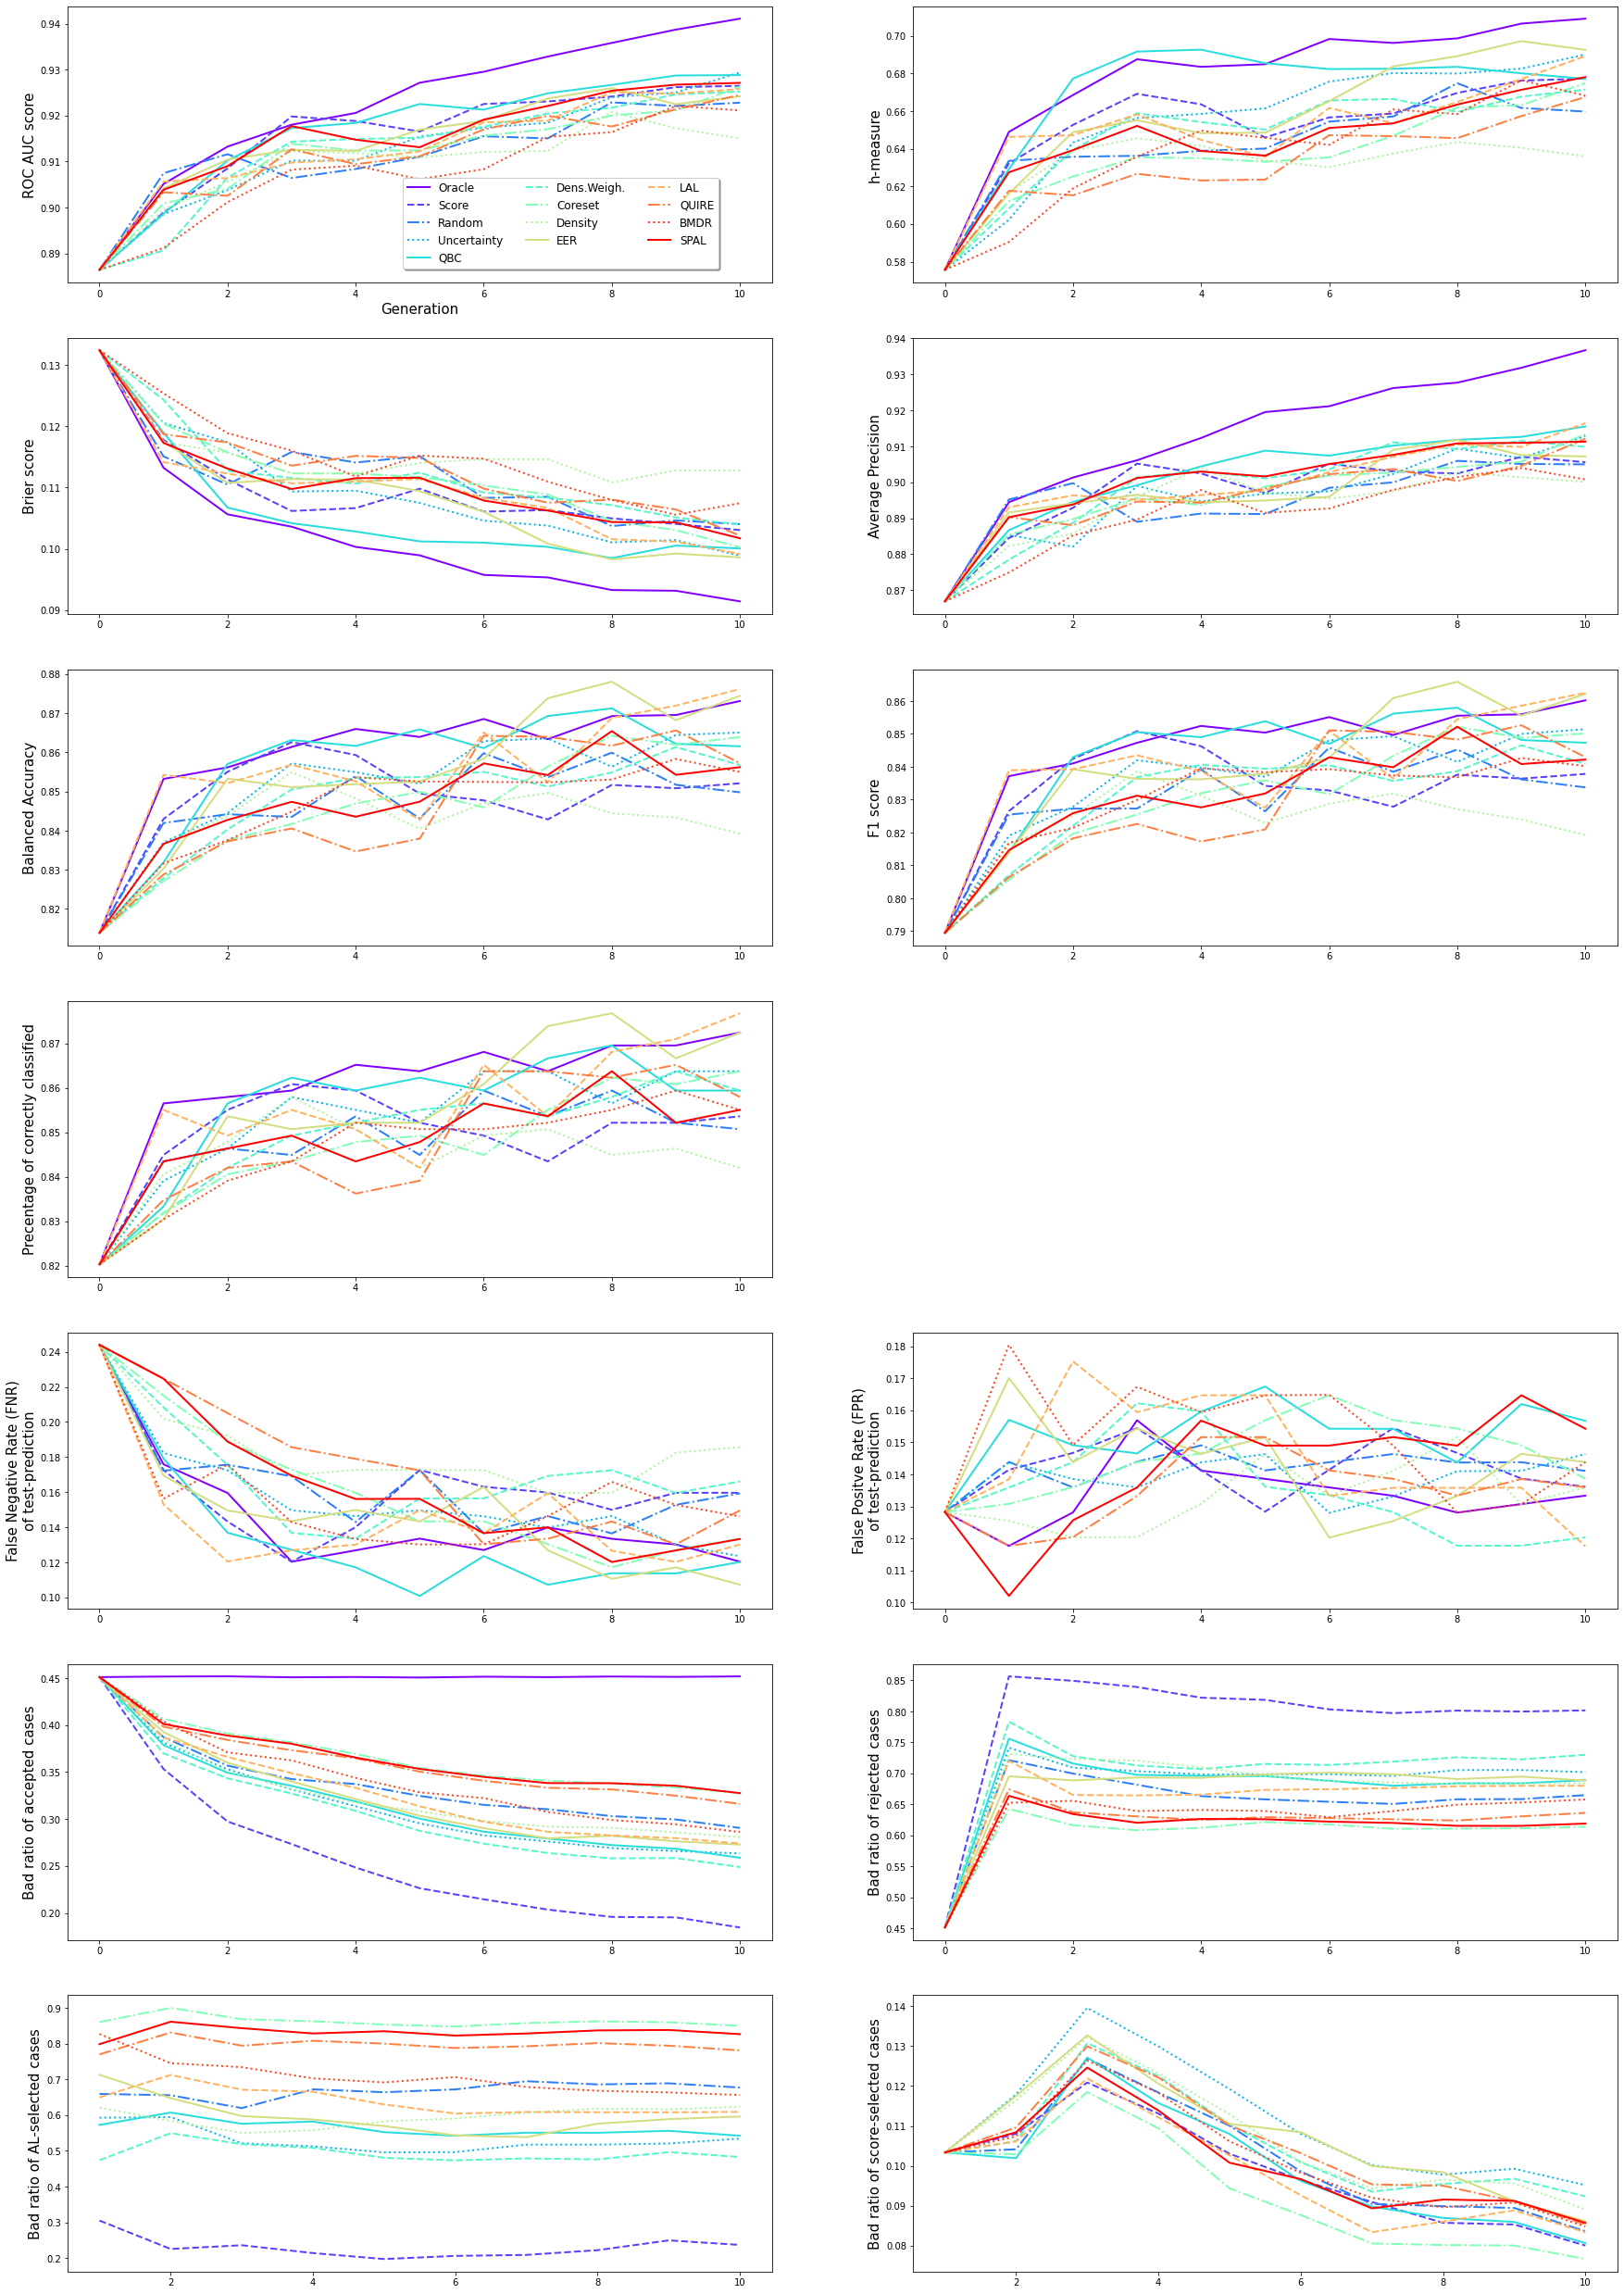

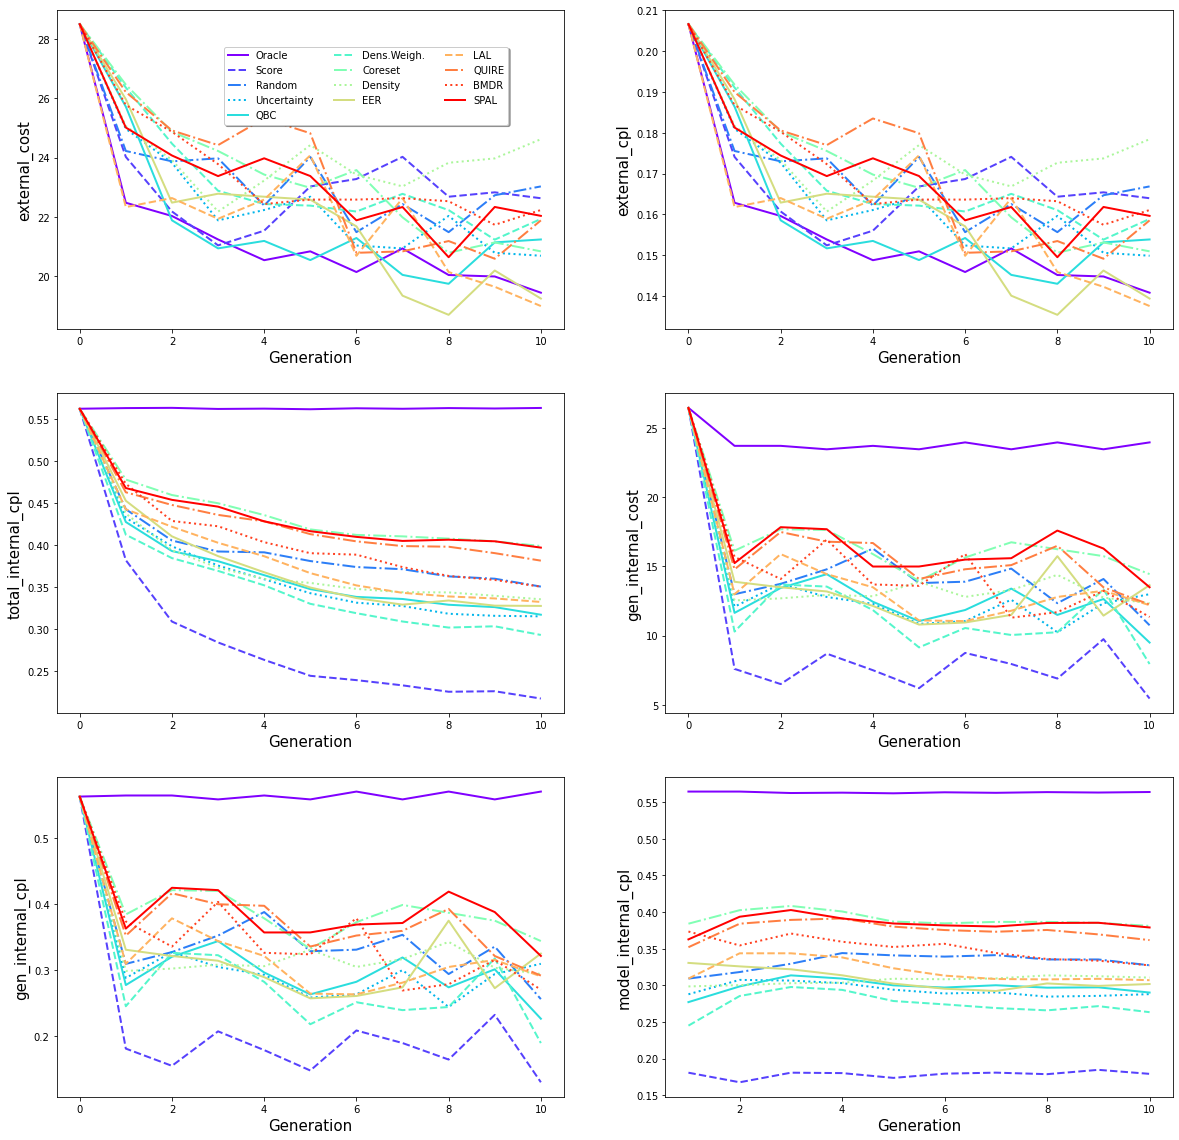

In [ ]:
############################################
# RUN LOOP THAT ITERATES OVER ALL AL MODELS
############################################

#### SET UP MODEL
classifier=LogisticRegression(random_state=seed) 

AL_models = dict(
    oracle=['Oracle', 'Oracle'],
    score=['Score','Score'],
    random=['Random','QueryInstanceRandom'],
    
    unc=['Uncertainty','QueryInstanceUncertainty'],
    qbc=['QBC','QueryInstanceQBC'],
    dw=['Dens.Weigh.', 'QueryInstanceDensityWeighted'],
    cors=['Coreset','QueryInstanceCoresetGreedy'],

    density=['Density','QueryInstanceGraphDensity'],
    eer = ['EER', 'QueryExpectedErrorReduction'],
    lal= ['LAL','QueryInstanceLAL'],
    quire=['QUIRE','QueryInstanceQUIRE'], ### slow, no batch mode, samples need to be picked one by one with a for-loop
    bmdr=['BMDR','QueryInstanceBMDR'], #only if cvxpy installed
    spal=['SPAL','QueryInstanceSPAL'] #only if cvxpy installed
    )

#store different filenames after each run, making loading of results easier
filename_list=[]

######################################
# run loop for all datasets, AL-score ratios and models; save results, create averages for all metrics (generation-wise averages over all rounds)
######################################

for dataset in dataset_list:

  X,y = data_loader(dataset)

  # intialize result dictionaries
  AL_stats={}
  AL_indices={}
  AL_cost={}

  ######################################
  # generate Kfold data splits
  # this generates the data for each round!
  # note: test set is different in each round!

  skf = StratifiedKFold(n_splits=rounds, shuffle = True, random_state=seed)
  idx = []
  for train_index, test_index in skf.split(X, y):
    idx.append((train_index, test_index))


  # load tuned parameters, check that parameters for all models are set
  param_dict = param_getter(tuned=tuned, dataset = dataset)
  try:
    assert len(param_dict)==13
  except AssertionError:
    print("parameters incomplete")

  # for each dataset, loop over differen AL-score ratios
  for cost_mat in cost_mat_list:

    #filename to load tuned thresholds based on cost matrix
    fname = 'tuned_thresholds'
    if cost_mat is not None:
      #augment filename to load the correct file, only needed for non-dynamic, pre-determined cost matrices (not part of the experiment)
      fname += f"_cost-{cost_mat[0][1]}-{cost_mat[1][0]}"

    infile = open(fname,'rb')
    tuned_thresholds = pickle.load(infile)
    infile.close()
    print('tuned thresholds: ',tuned_thresholds)

    for wght in weights:
      for r_AL in ratios_list:

        LOOP_params = loop_param_setter(X, max_gens=max_gens, total_rounds=rounds, AL_acc_rate=r_AL, cost_mat=cost_mat, dataset=dataset, weights=wght)

        ### Build filename for saving results
        filename = "{}_".format(dataset)

        for key in LOOP_params:
          if key not in ["init_sample", "sample_size", "score_acc_rate", "w_factor", "tuned_threshold", "dataset_name"]:
            filename += f"_{key}-{LOOP_params[key]}"

        filename = filename.replace('.', '-')
        filename = filename.replace('[', '')
        filename = filename.replace(']', '')
        filename = filename.replace(',', '-')
        filename = filename.replace(' ', '')
        print(filename)

        print(f'\n----------- STARTING LOOP FOR DATASET {dataset} ------------')
        start = time.time()
        starttime = datetime.datetime.now()
        print("start time: ", starttime)

        for key in AL_models:
          AL_stats["{}".format(key)] = {}
          AL_indices["{}".format(key)] = {}
          AL_cost["{}".format(key)] = {}

          AL_params = param_dict[key]['AL']
          AL_params.pop('skip', None) #Baseline models oracle, random & score skip the sampler-step in the CV loop and only tune the clf. skip parameter is not needed here
          AL_params.pop('with_scaling', None) #Baseline models oracle, random & score skip the sampler-step in the CV loop and only tune the clf. skip parameter is not needed here
          CLF_params=param_dict[key]['CLF']
        
          print(AL_params)
          
          for rnd in range(rounds):
            stats, indices, cost = AL_loop(data=X, 
                                          y=y, 
                                          kf_indices=idx, 
                                          key = key,
                                          seed=seed, 
                                          classifier = classifier, 
                                          AL_models=AL_models, 
                                          iteration = rnd, 
                                          AL_params=AL_params, 
                                          CLF_params=CLF_params, 
                                          **LOOP_params)

            AL_stats["{}".format(key)][rnd] = copy.deepcopy(stats)
            AL_cost["{}".format(key)][rnd] = copy.deepcopy(cost)
            if store_indices == True:
              AL_indices["{}".format(key)][rnd] = copy.deepcopy(indices)

          #build average scores across all folds (rounds)  
          AL_stats["{}".format(key)]['average'] = pd.concat(AL_stats["{}".format(key)]).groupby(level=1).mean()
          AL_cost["{}".format(key)]['average'] = pd.concat(AL_cost["{}".format(key)]).groupby(level=1).mean()

          with open(f'model_results/{dataset}/{filename}', 'wb') as a_file:
            pickle.dump(AL_stats, a_file)

          with open(f'model_cost/{dataset}/{filename}', 'wb') as b_file:
            pickle.dump(AL_cost, b_file)
          
          a_file.close()
          b_file.close()

          if store_indices == True:
            with open(f'model_indices/{dataset}/{filename}', 'wb') as c_file:
              pickle.dump(AL_indices, c_file)
            c_file.close()


        ######################################
        # print and save results
        ######################################

        print(' \n \n ################################## \n ------------- RESULTS ------------- \n ################################## \n \n')
        for key in AL_models:
          print("\n \n dataset {}: average results for strategy {}: \n \n".format(dataset, AL_models[key][0]), (AL_stats["{}".format(key)]["average"]), "\n \n \n")

        print(filename)
        stats_plotter(AL_stats)
        #plt.savefig(f'result_images/{dataset}/STATS_{filename}.png', bbox_inches='tight')

        print(' \n \n ################################## \n ------------- COST ------------- \n ################################## \n \n')
        for key in AL_models:
          print("\n \n dataset {}: average cost for strategy {}: \n \n".format(dataset, AL_models[key][0]), (AL_cost["{}".format(key)]["average"]), "\n \n \n")

        cost_metrics = ["external_cost", "external_cpl", "total_internal_cpl", "gen_internal_cost", "gen_internal_cpl", "model_internal_cpl"] #"total_internal_cost","model_internal_cost",
        print(filename)
        cost_plotter(AL_cost, cost_metrics)
        #plt.savefig(f'result_images/{dataset}/COST_{filename}.png', bbox_inches='tight')

        end = time.time()
        endtime = datetime.datetime.now()
        print(f"start at {starttime}, end at {endtime}")
        print('total time (hours): ', (start-end)/360)